In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv('quasar_train.csv')
train.shape

(200, 450)

In [3]:
train.head()

,1150.000,1151.000,1152.000,1153.000,1154.000,1155.000,1156.000,1157.000,1158.000,1159.000,...,1590.000,1591.000,1592.000,1593.000,1594.000,1595.000,1596.000,1597.000,1598.000,1599.000
0,0.629,1.910,0.976,2.161,0.964,2.068,1.630,1.716,2.378,-0.540,...,0.532,1.462,0.323,2.515,1.194,0.654,1.056,1.450,0.203,0.382
1,-0.161,1.830,0.609,1.932,0.932,0.857,0.978,1.032,1.793,1.455,...,0.961,1.407,1.296,0.943,1.055,2.265,1.053,1.439,0.767,-0.552
2,-0.085,-1.304,0.691,-0.800,-1.090,1.087,0.734,1.198,1.122,0.742,...,0.447,1.139,0.422,1.248,1.047,0.500,1.514,1.623,1.202,0.924
3,1.283,-0.487,0.660,0.167,-1.217,1.535,2.264,0.220,0.865,-0.723,...,0.714,1.173,1.579,0.477,0.781,0.525,2.466,1.493,1.503,0.698
4,-0.107,0.328,0.681,2.500,0.083,1.876,2.359,1.122,0.584,0.835,...,1.427,2.685,1.152,1.365,0.280,2.246,1.249,1.304,0.578,0.831


In [4]:
test=pd.read_csv('quasar_test.csv')
test.shape

(50, 450)

In [5]:
col=train.columns.values.astype(float).astype(int)

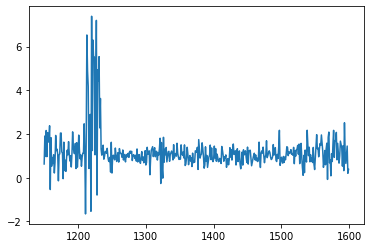

In [6]:
plt.plot(col,train.loc[0])

In [7]:
x0=np.ones(train.shape[1])
x1=col
y=train.head(1).values.ravel()
x=np.stack([x0,x1]).T
print(x.shape,y.shape)

(450, 2) (450,)


In [8]:
def get_theta(x,y,W=None):
    if W is None:
        return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    else:
        return np.linalg.inv(x.T.dot(W).dot(x)).dot(x.T).dot(W).dot(y)

In [9]:
def weight(x,xi,tau=5):
    return np.diag(np.exp(-(x[:,1]-xi[1])**2/(2*tau**2)))

In [10]:
res=[]
for k,xi in enumerate(x):
    W=weight(x,xi)
    theta=get_theta(x,y,W)
    res.append(theta.dot(xi))

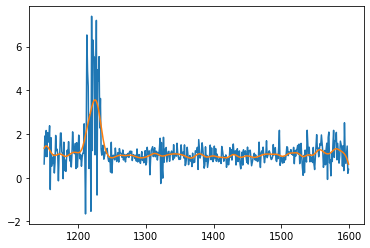

In [11]:
plt.plot(col,train.loc[0].values)
plt.plot(col,res)

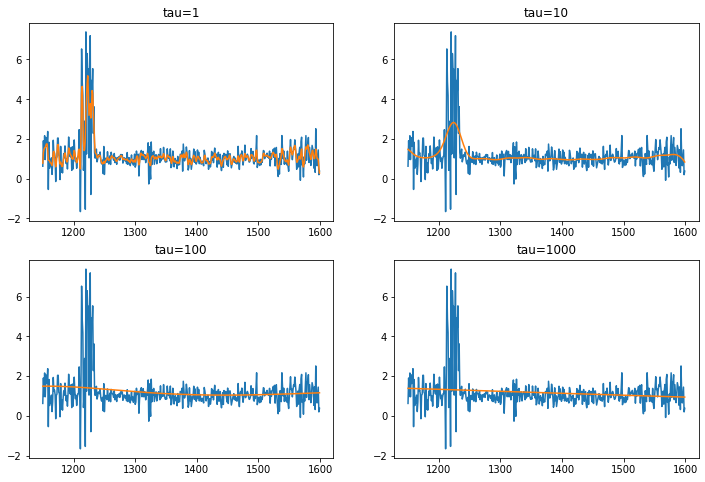

In [12]:
fig,axes=plt.subplots(2,2,figsize=(12,8))
axes=axes.ravel()
for k,tau in enumerate([1,10,100,1000]):
    ax=axes[k]
    res=[]
    for xi in x:
        W=weight(x,xi,tau)
        theta=get_theta(x,y,W)
        res.append(theta.dot(xi))
    ax.plot(col,train.loc[0].values)
    ax.plot(col,res)
    ax.set_title('tau={0}'.format(tau))

In [13]:
def smooth(x,y,xs,tau):
    thetas=[]
    for xi in xs:
        W=weight(x,xi,tau)
        theta=get_theta(x,y,W)
        thetas.append(theta)
    return thetas

In [14]:
smoothed_train=[]
x=np.stack([np.ones(train.shape[1]),col]).T
for k,row in train.iterrows():
    y=row.values
    thetas=smooth(x,y,x,5)
    s_val=[t.dot(xx) for (t,xx) in zip(thetas,x)]
    smoothed_train.append(s_val)


In [15]:
s_train=pd.DataFrame(smoothed_train, columns=train.columns.astype(float).astype(int))
print(s_train.shape)

(200, 450)


In [16]:
smoothed_test=[]
x=np.stack([np.ones(test.shape[1]),col]).T
for k, row in test.iterrows():
    y=row.values
    thetas=smooth(x,y,x,5)
    s_val=[t.dot(xx) for (t,xx) in zip(thetas,x)]
    smoothed_test.append(s_val)

In [17]:
s_test=pd.DataFrame(smoothed_test,columns=train.columns.astype(float).astype(int))
print(s_test.shape)

(50, 450)


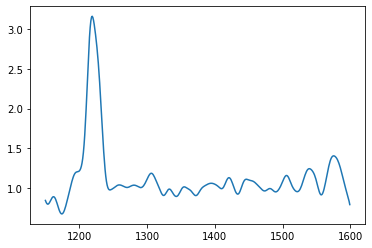

In [18]:
plt.plot(col,s_train.loc[23].values)

In [19]:
def ker(x):
    return np.max(1-x,0)
right=col[col>=1300]
left=col[col<1200]
train_left=s_train[left]
train_right=s_train[right]
print(train_right.shape)

(200, 300)


In [20]:
num_neib=4
errors=[]
res=[]
for k,row in train_right.iterrows():
    dists=((train_right-row)**2).sum(axis=1)
    maxdist=dists.max()
    neib_dist=dists.sort_values()[:num_neib]
    p1=np.sum([ker(d/maxdist)*train_left.loc[idx] for (idx,d) in neib_dist.iteritems()],axis=0)
    p2=np.sum([ker(d/maxdist) for (idx,d) in neib_dist.iteritems()])
    flh=p1/p2
    res.append(flh)
    errors.append(np.sum((flh-train_left.loc[k])**2))

In [21]:
np.mean(errors)

1.3050069327145195

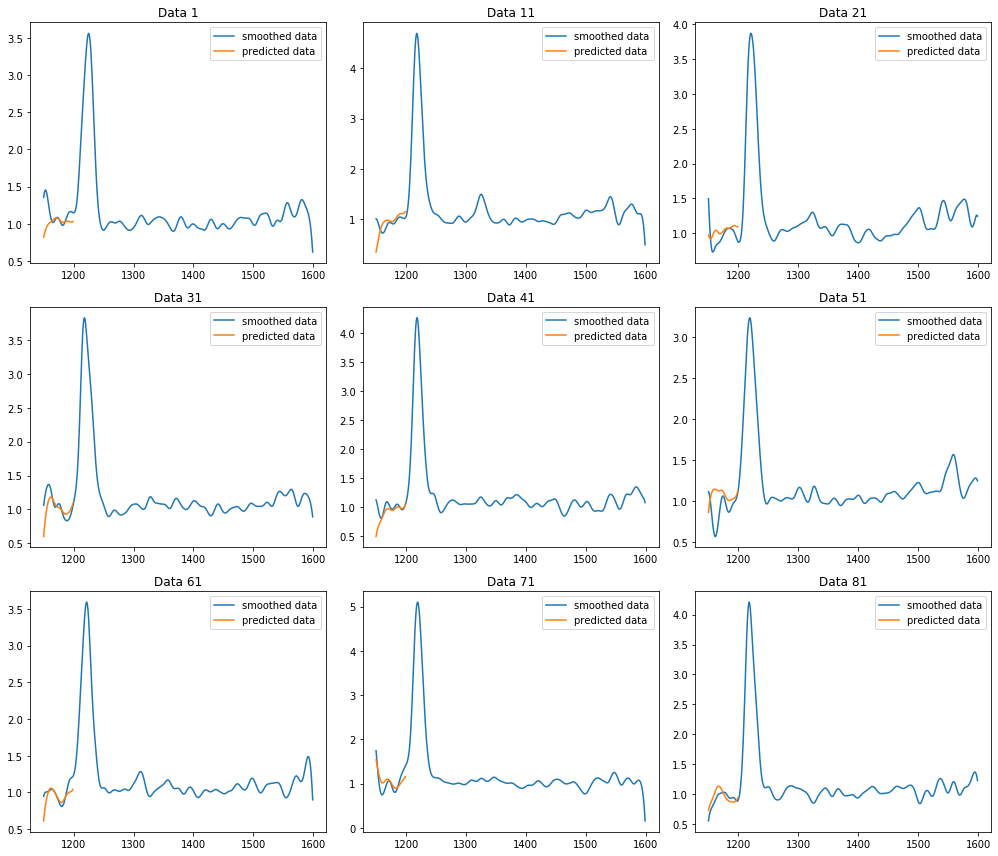

In [22]:
fig, axes=plt.subplots(3,3,figsize=(14,12))
axes=axes.ravel()

for k,idx in enumerate([0,10,20,30,40,50,60,70,80]):
    ax=axes[k]
    ax.plot(col,s_train.loc[idx],label='smoothed data')
    ax.plot(left,res[idx],label='predicted data')
    ax.legend()
    ax.set_title('Data {0}'.format(idx+1))
plt.tight_layout()

In [23]:
test_left=s_test[left]
test_right=s_test[right]
errors2=[]
res2=[]
for k,row in test_right.iterrows():
    dists=((train_right-row)**2).sum(axis=1)
    maxdist=dists.max()
    neib_dist=dists.sort_values()[:num_neib]
    p1=np.sum([ker(d/maxdist)*train_left.loc[idx] for (idx,d) in neib_dist.iteritems()],axis=0)
    p2=np.sum([ker(d/maxdist) for (idx,d) in neib_dist.iteritems()])
    flh=p1/p2
    res2.append(flh)
    errors2.append(np.sum((flh-test_left.loc[k])**2))

In [24]:
np.mean(errors2)

2.898203952148464

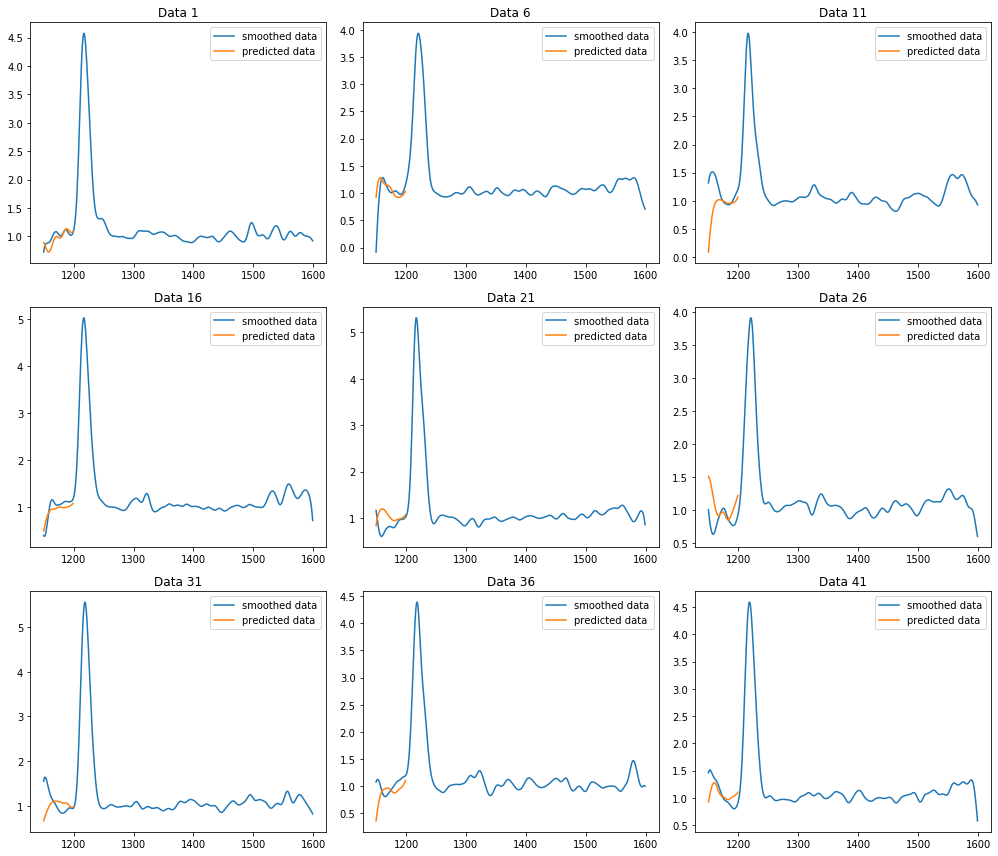

In [25]:
fig,axes=plt.subplots(3,3,figsize=(14,12))
axes=axes.ravel()
for k,idx in enumerate([0,5,10,15,20,25,30,35,40]):
    ax=axes[k]
    ax.plot(col,s_test.loc[idx],label='smoothed data')
    ax.plot(left,res2[idx],label='predicted data')
    ax.legend()
    ax.set_title('Data {0}'.format(idx+1))
plt.tight_layout()